![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_1/practica_3/practica_3.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

# **Pŕactica No. 3**
## **Visión por Computador**

## **Objetivos**
- Introducción a la extracción de características en imágenes
- Pipelines de procesamiento

## **Problema**
- El alzheimer es una enfermedad degenerativa que afecta a la población adulta en grandes proporciones a nivel mundial. A raíz de lo anterior, en un hospital se busca construir una herramienta que clasifique etapas del alzheimer con base en cortes de resonancia magnética tomadas de diferentes pacientes con el objetivo de diagnosticar lo más temprano posible y pensar en posibles tratamientos.



In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [2]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import utils.general as gen

from skimage import io, color, exposure, feature

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (confusion_matrix, precision_score, accuracy_score,
                             recall_score, classification_report)

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tqdm.auto import tqdm

In [3]:
data_id = "10pDfpxFAXkBGD29CfZQ7RaoIFMyyKpAI"

In [4]:
gen.download_file_from_google_drive(data_id, "alzheimer.zip", size=35718)

  0%|          | 0/35718 [00:00<?, ?KB/s]

  0%|          | 0/6404 [00:00<?, ?it/s]

Deleting File...


In [5]:
data_dir = gen.create_and_verify(
    "data", list_=True
)

In [6]:
data_dir

array(['data/MildDemented', 'data/ModerateDemented', 'data/NonDemented',
       'data/VeryMildDemented'], dtype='<U21')

In [7]:
data_counts = {
    "Label": [
        "Mild Demented",
        "Moderate Demented",
        "Non Demented",
        "Very Mild Demented"
    ],
    "Counts": [
        len(gen.read_listdir(data_dir[0])),
        len(gen.read_listdir(data_dir[1])),
        len(gen.read_listdir(data_dir[2])),
        len(gen.read_listdir(data_dir[3]))
    ]
}

data_counts = pd.DataFrame(data_counts)

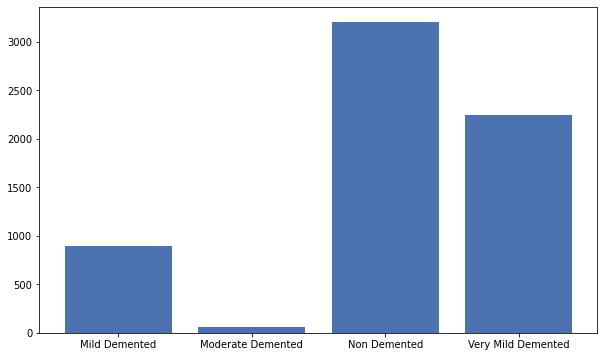

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(x=data_counts["Label"], height=data_counts["Counts"])
plt.show()

## **Visualización y Análisis**
- A primera vista, nos encontramos con un dataset de cortes de Resonancia Magnética en la secuencia de contraste T1, puesto que es la secuencia más utilizada en el análisis de enfermedades degenerativas, como es el caso del Alzheimer.
- Los profesionales a cargo de la obtención de datos recomiendan unir las imágenes de "Mild Demented" con "Moderate Demented" dado el bajo número de cortes.

In [9]:
data_dirs = []

for dir_ in data_dir:
    data_dirs.extend(gen.read_listdir(dir_))
data_dirs = np.array(data_dirs)

In [10]:
data_dirs

array(['data/MildDemented/26 (19).jpg', 'data/MildDemented/26 (20).jpg',
       'data/MildDemented/26 (21).jpg', ...,
       'data/VeryMildDemented/verymildDem997.jpg',
       'data/VeryMildDemented/verymildDem998.jpg',
       'data/VeryMildDemented/verymildDem999.jpg'], dtype='<U41')

In [11]:
full_train_dirs, test_dirs = train_test_split(data_dirs, test_size=0.2, random_state=1234)
train_dirs, val_dirs = train_test_split(full_train_dirs, test_size=0.2, random_state=1234)

In [12]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_dirs, hog=False):
        self.data_dirs = data_dirs
        self.label_map = {
            "MildDemented": 0,
            "ModerateDemented": 0,
            "NonDemented": 1,
            "VeryMildDemented": 2
        }
        self.hog = hog
    
    def __len__(self):
        return len(self.data_dirs)
    
    def size(self):
        return len(self)
    
    def __getitem__(self, idx):
        img_dir = self.data_dirs[idx]
        img = color.rgb2gray(io.imread(img_dir))
        if self.hog:
            img = feature.hog(img, multichannel=False)
        label = img_dir.split(os.path.sep)[-2]
        label = self.label_map[label]
        return img, label

In [13]:
train_generator = DataGenerator(train_dirs)
val_generator = DataGenerator(val_dirs)

In [14]:
np.random.seed(1234)
random_sample = np.random.choice(range(len(train_generator)), 9)
random_sample

array([2863,  723, 1318, 3125, 3276, 3444,  664, 2041, 3727])

In [15]:
imgs = []
labels = []

for i in random_sample:
    img, label = train_generator[i]
    imgs.append(img)
    labels.append(label)

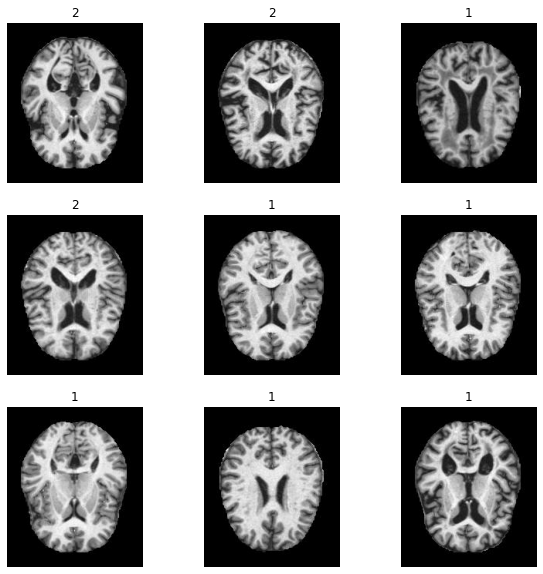

In [16]:
gen.visualize_subplot(imgs, labels, (3, 3), figsize=(10, 10))

## **Procesamiento**
### **Histograma de Gradientes Orientados**
![image](https://docs.google.com/uc?export=download&id=1zC8X95PdsDoUIo0KBZ390ylDAVaj48lw)
- El histograma de gradientes orientados es un algoritmo que se basa en la extracción de características morfológicas de una imagen con respecto a los gradientes (razones de cambio) en X e Y que se presenten a lo largo de los objetos presentes en ella.
> *Computer Vision: Algorithms and Applications.* R. Szeliski. Springer, 2011.

- Con qué objetivo se hace lo anterior? Extraer contornos, siluetas e información de las texturas.

In [ ]:
feature.hog?

In [17]:
imgs_hog = []
for img in imgs:
    _, img_hog = feature.hog(img, visualize=True, multichannel=False)
    imgs_hog.append(img_hog)

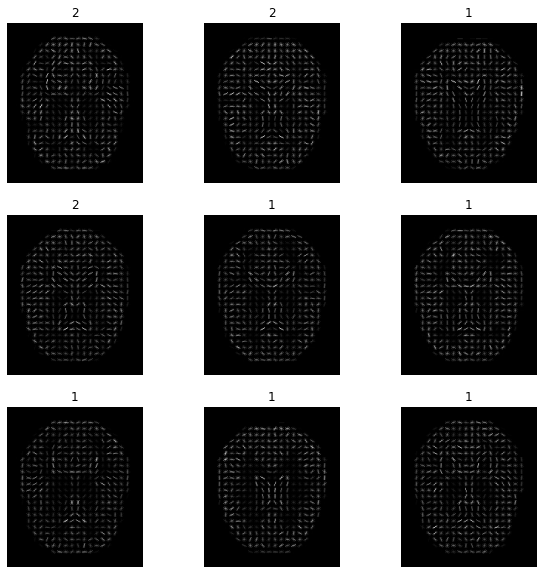

In [18]:
gen.visualize_subplot(imgs_hog, labels, (3, 3), figsize=(10, 10))

In [19]:
train_generator = DataGenerator(train_dirs, hog=True)
val_generator = DataGenerator(val_dirs, hog=True)

In [ ]:
X_train = []
y_train = []

for img, label in tqdm(train_generator):
    X_train.append(img)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_val = []
y_val = []

for img, label in tqdm(val_generator):
    X_val.append(img)
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_train.shape

(4096, 38880)

## **Modelado**
- Dado que ya tenemos un primer procesamiento, ahora vamos a modelar con un perceptrón multicapa.

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(3, activation="softmax")
])

In [ ]:
model.compile(
    optimizer="adam", 
    loss=keras.losses.SparseCategoricalCrossentropy(name="loss"), 
    metrics=["acc"]
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=12, validation_data=(X_val, y_val),
    batch_size=32
)

Epoch 1/12
128/128 [==============================] - 4s 8ms/step - loss: 1.0517 - acc: 0.5187 - val_loss: 0.8379 - val_acc: 0.6123
Epoch 2/12
128/128 [==============================] - 1s 5ms/step - loss: 0.7221 - acc: 0.6789 - val_loss: 0.6760 - val_acc: 0.6885
Epoch 3/12
128/128 [==============================] - 1s 5ms/step - loss: 0.5402 - acc: 0.7919 - val_loss: 0.6170 - val_acc: 0.7090
Epoch 4/12
128/128 [==============================] - 1s 5ms/step - loss: 0.3854 - acc: 0.8613 - val_loss: 0.5233 - val_acc: 0.7764
Epoch 5/12
128/128 [==============================] - 1s 5ms/step - loss: 0.2716 - acc: 0.8984 - val_loss: 0.4235 - val_acc: 0.8262
Epoch 6/12
128/128 [==============================] - 1s 5ms/step - loss: 0.1682 - acc: 0.9572 - val_loss: 0.3278 - val_acc: 0.8730
Epoch 7/12
128/128 [==============================] - 1s 5ms/step - loss: 0.1311 - acc: 0.9652 - val_loss: 0.3146 - val_acc: 0.8740
Epoch 8/12
128/128 [==============================] - 1s 5ms/step - loss: 0.

In [ ]:
history = pd.DataFrame(history.history)

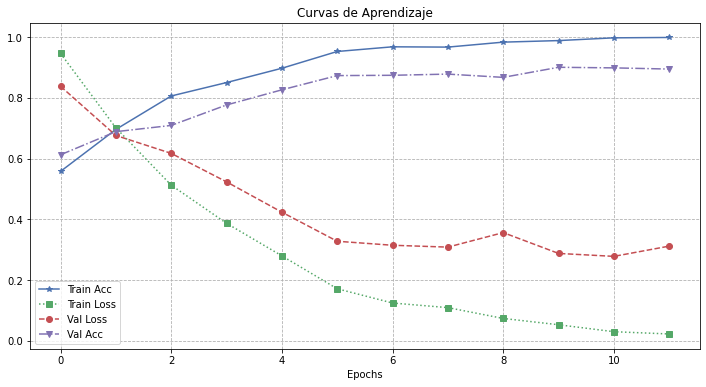

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history["acc"], "*", label="Train Acc", linestyle="solid")
plt.plot(history["loss"], "s", label="Train Loss", linestyle="dotted")
plt.plot(history["val_loss"], "o", label="Val Loss", linestyle="dashed")
plt.plot(history["val_acc"], "v", label="Val Acc", linestyle="dashdot")
plt.title("Curvas de Aprendizaje")
plt.xlabel("Epochs")
plt.legend(loc="best")
plt.grid(linestyle="--")
plt.show()

In [ ]:
del model

* Modelado (Keras, Perceptrón Multicapa).
* Otro Dataset.
* Random Search Tuneo de Hiperparámetros. Función de Activación y Número de Epochs, número de neuronas por capas, 2 capas.

In [ ]:
def build_model(activation="relu", units=32):
    model = keras.Sequential([
        keras.layers.Dense(
            units * 2, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(
            units, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(3, activation="softmax")
    ])

    loss = keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer="adam", loss=loss, metrics=["acc"])
    return model

In [ ]:
model = KerasClassifier(build_fn=build_model, batch_size=32)

In [ ]:
param_grid = {
    "epochs": [5, 10],
    "activation": ["relu", "elu"],
    "units": [64, 128]
}

In [ ]:
random_search = RandomizedSearchCV(model, param_grid)

In [ ]:
random_search.fit(X_train, y_train)

In [ ]:
print(f"Mejor puntaje: {random_search.best_score_} usando {random_search.best_params_}")

Mejor puntaje: 0.8603618383407593 usando {'units': 64, 'epochs': 10, 'activation': 'relu'}


## **Validación**

In [ ]:
del X_train, y_train
del X_val, y_val

In [ ]:
model = random_search.best_estimator_

In [ ]:
test_generator = DataGenerator(test_dirs, hog=True)

In [ ]:
X_test = []
y_test = []

for img, label in tqdm(test_generator):
    X_test.append(img)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

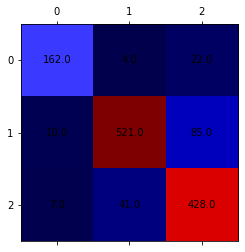

In [ ]:
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap="seismic")

for (i, j), z in np.ndenumerate(conf_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

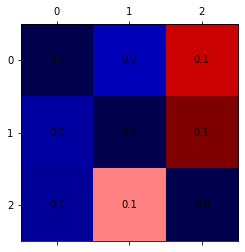

In [ ]:
fig, ax = plt.subplots()
ax.matshow(norm_conf_mat, cmap="seismic")

for (i, j), z in np.ndenumerate(norm_conf_mat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [ ]:
precision_score(y_test, y_pred, average="weighted")

0.8734140518585782

In [ ]:
recall_score(y_test, y_pred, average="weighted")

0.86796875

In [ ]:
accuracy_score(y_test, y_pred)

0.86796875

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       188
           1       0.92      0.85      0.88       616
           2       0.80      0.90      0.85       476

    accuracy                           0.87      1280
   macro avg       0.88      0.87      0.87      1280
weighted avg       0.87      0.87      0.87      1280

